# Direct Fidelity Estimation

Using a method known as direct fidelity estimation (DFE), see [DFE1] and [DFE2], it is possible to estimate the fidelity between 
* a target pure state $\rho_\psi = |\psi\rangle\langle \psi|$ and its experimental realization $\sigma$,
* a target unitary $U$ and its experimental realization $U_e$.
 
This can be done with a small number (relative to state and process tomography) of simple experimental settings that is independent of the system size. Such methods are useful for the experimental study of larger quantum information processing units.

In this notebook we explore some state and process DFE using the forest.benchmarking module `direct_fidelity_estimation.py`.

| [DFE1] *Practical Characterization of Quantum Devices without Tomography.*  
|        Silva et al.  
|        PRL 107, 210404 (2011).  
|        https://doi.org/10.1103/PhysRevLett.107.210404  
|        https://arxiv.org/abs/1104.3835  

| [DFE2]  *Direct Fidelity Estimation from Few Pauli Measurements.*  
|        Flammia et al.  
|        PRL 106, 230501 (2011).  
|        https://doi.org/10.1103/PhysRevLett.106.230501  
|        https://arxiv.org/abs/1104.4695  

## Simplistic state DFE example

Suppose we have tried to prepare the state $|0\rangle$, with state matrix $\rho_0 = |0\rangle \langle 0 |$, but in fact prepared the state

$$\sigma = \frac 1 2 (I + x X + y Y + z Z)$$


The usual way to quantify how close $\sigma$ and $\rho_0$ are is to use quantum state tomography 
to estimate $\sigma$ and then calculate the fidelity between $\sigma$ and $\rho_0$.


DFE provides a way to directly estimate the fidelity without first estimating the state $\sigma$. To see this, first note that since $\rho_0$ is a pure state (our estimate $\sigma$ in general is not) we can write the [fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states#Definition) as $F(\rho_0, \sigma) = \langle 0 |\sigma|0 \rangle$. This is equivalent to 

$$F(\rho_0, \sigma) = {\rm Tr}[\rho_0  \sigma]$$

using the [cyclic property of the trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra%29#Cyclic_property). 
Next we parameterize the pure state as

$$\rho_0= |0\rangle \langle 0| =  \frac 1 2 \big (I + (0) X + (0) Y + (+1) Z \big)=  \frac 1 2 (I +  Z )$$

Finally we arrive at

$$F(\rho_0, \sigma)= {\rm Tr}[\rho_0 \sigma] = \frac 1 4 {\rm Tr}[(1+z)I]= \frac{(1+z)}{2}$$

This result shows that we only need to estimate one observable expectation $\langle Z \rangle \rightarrow \tilde z$ in order to estimate the fidelity between $\rho_0$ and $\sigma$ in this particular example.

## Generalizing state DFE, somewhat

The code that we've developed has some assumptions baked in that are important to understand. We have implemented DFE for a restricted subset of states and processes using these assumptions.

To start, we assume that our start state is always the pure state $|0 \rangle$ on all qubits. On $n$ qubits this state can be decomposed as

$$\rho_0^{\otimes n} = \left(I_0 + Z_0\right) \otimes \left(I_1 + Z_1\right) \otimes \dots \left(I_n + Z_n\right) / 2^n  = \frac{1}{2^n} \sum_{k=1}^{2^n} P^{(IZ)}_k$$

where we have expanded the tensor multiplication into one large sum over all possible of combinations $P^{(IZ)}_k$ of I and Z Pauli terms. From this start point we apply the user specified program $U$, or rather the noisy implementation $\mathcal E( \cdot )$, to prepare the state $\sigma$. 

$$\sigma = \mathcal E(\rho_0^{\otimes n})$$

Meanwhile we want to calculate the fidelity between $\sigma$ and the ideally prepared state $\rho = U \rho_0^{\otimes n} U^\dagger$. By linearity we can calculate $\rho$ by conjugating each Pauli term $P^{(IZ)}$ in the sum above by the ideal program $U$.

$$\rho = \frac{1}{2^n} \sum_k U P^{(IZ)}_k U^\dagger$$

**The assumption** we make is that the ideal prep program $U$ is an element of the Clifford group. Since the Clifford group is the [normalizer](https://en.wikipedia.org/wiki/Centralizer_and_normalizer) of the Pauli group, these conjugated terms $U P^{(IZ)}_k U^\dagger$ will again be some Pauli $P'_k$ (in the code we use a `pyquil.BenchmarkConnection` to quickly calculate the resultant Pauli). Following the example above we arrive at the set of $2^n$ Paulis $\{P'_k\}_k$ whose expectations we need to estimate with respect to the physical state $\sigma$. The estimate is the average of all these Pauli expectations (see Eqn. 1 of [DFE1]). 

$$F(\rho_0^{\otimes n}, \sigma)= {\rm Tr}[\rho_0^{\otimes n} \sigma] = \frac{1}{2^n} \sum_{k=1}^{2^n} {\rm Tr}[ \mathcal E(\rho_0^{\otimes n}) P'_k]$$

Note that we don't need to estimate the expectation of the trivial all $I$ term since we know its expectation is 1. We exclude this term in experiment generation but include it in the analysis 'by hand'. 

## Process DFE

The [average gate fidelity](https://arxiv.org/pdf/quant-ph/0205035.pdf) between an experimental process $\mathcal E$ and the ideal (unitary) process $\mathcal U$ is given by

$$F(\mathcal U,\mathcal E) = \frac{ {\rm Tr} [\mathcal E \mathcal U^\dagger] + d} {d^2+d}$$

where the processes are represented by linear superoperators acting on vectorized
density matrices, and d is the dimension of the Hilbert space $\mathcal H$ that $\mathcal E$ and $\mathcal U$ act on. If you are unfamiliar with these terms look at [superoperator tools notebook](superoperator_tools.ipynb) and [superoperator_representations.md](../superoperator_representations.rst)

Using the $d^2$ dimensional orthonormal Pauli basis $\{P_k\}$ for superoperators on $\mathcal H$--e.g. $\{I/\sqrt{2}, X/\sqrt{2}, Y/\sqrt{2}, Z/\sqrt{2} \}$ for a single qubit--we can expand the trace and insert an identity superoperator between $\mathcal U$ and $\mathcal E$; this amounts to re-casting these superoperators in the Pauli-Liouville representation (aka Pauli Transfer Matrix). (again, see [superoperator_representations.md](../superoperator_representations.rst) if you are unfamiliar with vec notation $P_k \iff \left| P_k \rangle\rangle\langle\langle P_k\right|$):

$${\rm Tr} [\mathcal E \mathcal U^\dagger] = {\rm Tr} [\mathcal E   \left( \sum_k \left| P_k \rangle\rangle\langle\langle P_k\right| \right) \mathcal U^\dagger]$$

$$= \sum_k {\rm Tr} [  \left( \langle\langle P_k | \mathcal U^\dagger \right) \left(\mathcal E | P_k \rangle\rangle \right) ]$$

$$= \sum_k {\rm Tr} [  \left( \mathcal U |  P_k \rangle\rangle  \right)^\dagger \left(\mathcal E | P_k \rangle\rangle \right) ]$$

Now we switch representations by unveccing  $|  P_k \rangle\rangle$ and representing $\mathcal U$ by its unitary action on the matrix $P_k$.

$$= \sum_k {\rm Tr} [  \left( U P_k U^\dagger \right)^\dagger \cdot \mathcal E \left( P_k \right) ]$$

Finally we can decompose the $P_k$ acted on by $\mathcal E$ into a sum over projectors onto each eigenvector $\left|\phi_j \rangle\langle \phi_j \right|$ with the correct sign for the eigenvalue (which is $\pm 1$ for Paulis).

$$= \sum_k \left( \sum_{\phi_j^{(+)} \in \{\phi\}_k^+} \frac{1}{\sqrt{d}} {\rm Tr} [  \left( U P_k U^\dagger \right) \cdot \mathcal E \left( \left|\phi_j^{(+)}\rangle\langle\phi_j^{(+)}\right| \right) ]
- \sum_{\phi_j^{(-)} \in \{\phi\}_k^-} \frac{1}{\sqrt{d}} {\rm Tr} [  \left( U P_k U^\dagger \right) \cdot \mathcal E \left( \left|\phi_j^{(-)}\rangle\langle\phi_j^{(-)}\right| \right) ]\right)$$

At this point our **assumption** that $U$ is a Clifford element again comes into play and allows us to easily compute the conjugated Pauli $U P_k U^\dagger = \sigma_k / \sqrt{d}$. Inserting this assumption gives a simple picture where we need to estimate the expectation of each $\sigma_k$ Pauli for the state which results from applying our noisy circuit $\mathcal E$ to each eigenstate $\left| \phi_j \rangle \right.$ of $P_k$.

$$= \frac{1}{d} \sum_k \left( \sum_{\phi_j^{(+)} \in \{\phi\}_k^+} {\rm Tr} [ \sigma_k \cdot \mathcal E \left( \left|\phi_j^{(+)}\rangle\langle\phi_j^{(+)}\right| \right) ]
- \sum_{\phi_j^{(-)} \in \{\phi\}_k^-} {\rm Tr} [  \sigma_k \cdot \mathcal E \left( \left|\phi_j^{(-)}\rangle\langle\phi_j^{(-)}\right| \right) ]\right)$$

The final estimate of $F(\mathcal U,\mathcal E)$ follows from estimating these expectations, plugging them in to the sum to get ${\rm Tr} [\mathcal E \mathcal U^\dagger]$ which we insert into the equation at the beginning of the section. Note that moving a factor of $1/d$ from the Fidelity expression into the trace expression allows us to re-interpret the trace as an average of all of the $d^3$ Pauli expectations. Further, again note that we do not need to estimate the all identity Pauli expectations, which will all be 1. This reduces the number of experiment settings to $(d^2-1)d$.


## Process DFE by reduction to state DFE

We can also understand process DFE by appealing to the [Choi–Jamiołkowski isomorphism](https://en.wikipedia.org/wiki/Channel-state_duality) which says that we can represent our channel superoperators as state matrices (i.e. density matrices)  $J(\mathcal E)$ and $J(\mathcal U)$. This allows us to rewrite the average gate fidelity as 

$$F(\mathcal U,\mathcal E)= \frac{d^2 {\rm Tr}[ J(\mathcal E)⋅J(\mathcal U)] + d}{d^2+d}$$

Finally, since $J(\mathcal U)$ is a pure state, we employ the same fact from above about fidelity between states to note that ${\rm Tr}[ J(\mathcal E)⋅J(\mathcal U)] = F(J(\mathcal E),J(\mathcal U))$. We have reduced process DFE to state DFE, but we need to dive into the particulars of $J(\cdot)$ to understand what we actually need to measure.

For $U$ acting on $n$ qubits the state $J(\mathcal U)$ over $2n$ qubits is given by 

$$J(\mathcal U) = \left(\textrm{Id} \otimes \mathcal U\right) \left(\sum_{k=0}^{2^n-1}\sum_{k'=0}^{2^n-1} |k\rangle \langle k'| \otimes |k \rangle \langle k'|\right) = \sum_{k=0}^{2^n-1}\sum_{k'=0}^{2^n-1} |k\rangle \langle k'| \otimes U |k \rangle   \langle k'| U^\dagger$$

where $|k \rangle$ is the state over $n$ qubits corresponding to the binary representation of $k$. The state matrix for the maximally entangled state on which $\textrm{Id} \otimes \mathcal U$ acts can be decomposed as:

$$\sum_{k=0}^{d-1} \sum_{k'=0}^{d-1} | k k \rangle \langle k' k'| = \frac{1}{d}\sum_j P_j^* \otimes P_j$$

where the sum is over the complete orthonormal Pauli basis $\{P_j\}$ (i.e. $\sigma_j/\sqrt{d}$) for a $d$ dimensional Hilbert space. This gives us

$$d^2 {\rm Tr}[ J(\mathcal E)⋅J(\mathcal U)] = d^2{\rm Tr}[ \left(\frac{1}{d}\sum_k P_k^* \otimes \mathcal E(P_k)\right) \left(\frac{1}{d}\sum_j P_j^* \otimes U P_j U^\dagger\right)]$$

If we partially evaluate the trace over the first subsystem and use ${\rm Tr}[P_k^* P_j^*] = {\rm Tr}[\left(P_k P_j\right)^*] = {\rm Tr}[P_k P_j]^* = {\rm Tr}[P_k^\dagger P_j]^* = \delta_{jk}$ we get 

$$= \sum_k {\rm Tr} [  \left( U P_k U^\dagger \right)^\dagger \cdot \mathcal E \left( P_k \right) ]$$

This is the same expression as from the last section, so we can proceed identically.

In [1]:
from pyquil.paulis import ID
from pyquil.gates import I, X, MEASURE, H, CNOT, RY, CZ
from pyquil import Program, get_qc
from pyquil.api import get_benchmarker
from forest.benchmarking.direct_fidelity_estimation import ( generate_exhaustive_state_dfe_experiment, 
                                                             generate_exhaustive_process_dfe_experiment,
                                                             generate_monte_carlo_state_dfe_experiment, 
                                                             generate_monte_carlo_process_dfe_experiment,
                                                             acquire_dfe_data,
                                                             estimate_dfe )

import numpy as np
from matplotlib import pyplot

In [2]:
# noiseless QVM
qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
noisy_qvm = get_qc("9q-generic-qvm", as_qvm=True, noisy=True)

bm = get_benchmarker()

## Direct fidelity estimation in `forest.benchmarking`

The basic workflow is:

1. Prepare a *state* or a *process* by specifying a pyQuil program.
2. Construct a list of observables that are needed to estimate the state; we collect this into an object called an `ObservablesExperiment`.
3. Acquire the data by running the program on a QVM or QPU.
4. Apply an estimator to the data to obtain an estimate of the fidelity between the ideal and measured state or process.
5. Visualize if you wish.

## Two quick examples

### Step 1. Specify a state preparation or unitarty process with a `Program`

This is the object we will do DFE on.

The process we choose is 

$$U = {\rm CNOT}(H\otimes I)=\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 0 & 1 & 0\\
0 & 1 & 0 & 1\\
0 & 1 & 0 & -1\\
1 & 0 & -1 & 0
\end{pmatrix}$$

and the state is

$$|\Psi\rangle = {\rm CNOT}(H\otimes I)|00\rangle = \frac{1}{\sqrt{2}} \begin{pmatrix} 1\\0\\0\\ 1\end{pmatrix}$$

Perhaps we should emphasize that while the `Program` that we pass into the DFE module is the same whether we are doing process DFE on $\tilde U$ or state DFE on $\tilde \Psi$, the specific experiment construction method we choose in the next step selects one or the other and results in different `ExperimentSettings` around the same `Program`.

In [3]:
p = Program()
prep_prog = p.inst(H(0), CNOT(0,1))
print(prep_prog)

H 0
CNOT 0 1



In [4]:
from pyquil.gate_matrices import I as Imatrix, H as Hmatrix, CNOT as CNOTmatrix

U_ideal = CNOTmatrix @ np.kron(Hmatrix, Imatrix)
print(U_ideal)

rho_ideal = U_ideal @ np.array([[1], [0], [0], [0]]) @ np.array([[1], [0], [0], [0]]).T @ U_ideal.conj().T
print(rho_ideal)

[[ 0.70710678  0.          0.70710678  0.        ]
 [ 0.          0.70710678  0.          0.70710678]
 [ 0.          0.70710678  0.         -0.70710678]
 [ 0.70710678  0.         -0.70710678  0.        ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]


### Step 2. Construct an `ObservablesExperiment` for DFE

We use the helper functions

* `generate_exhaustive_state_dfe_experiment` 
* `generate_exhaustive_process_dfe_experiment`

to construct a (tomographically incomplete) set of preparations + measurements (i.e. `ExperimentSettings`) for state and process DFE respectively

In [5]:
qubits = [0,1]

# state dfe
state_exp = generate_exhaustive_state_dfe_experiment(bm, prep_prog, qubits)

# process dfe
process_exp = generate_exhaustive_process_dfe_experiment(bm, prep_prog, qubits)

For state DFE we can print this experiment object out to see the $d - 1 = 2^2-1= 3$ observables whose expectation we will estimate (i.e. the measurements we will perform). Note that we could have included an additional observable `->I0I1`, but since this trivially gives an expectation of 1 we instead omit this observable in experiment generation and include its contribution by hand in the estimation methods. Be mindful of this if generating your own settings.

In [6]:
# Let's take a look into one of these experiment objects

print('The type of the object is:', type(state_exp),'\n')
print('The program is:')
print(state_exp.program)
print('There are three different settings:')
print(state_exp.settings_string())

The type of the object is: <class 'forest.benchmarking.observable_estimation.ObservablesExperiment'> 

The program is:
H 0
CNOT 0 1

There are three different settings:
0: Z+_0 * Z+_1→(1+0j)*Z0Z1
1: Z+_0 * Z+_1→(1+0j)*X0X1
2: Z+_0 * Z+_1→(-1+0j)*Y0Y1


Let's also look at a few of the settings for process DFE. Here our omission of trivial Identity terms means that we are summing over only the $d^2 - 1 = 15$ total unique observables measured. For each of these observables we prepare the $d = 4$ different initial preparations of eigenstates of the pre-circuit-conjugated observable. (For each Identity term of the pre-conjugated observable we still prepare two separate eigenstates, which we arbitrarily choose to be the two computational basis states on that qubit.) This gives us $60$ total settings.

Note that we have incorporated the minus sign into the observables paired with preparations of the negative eigenstates. This means that for ideal no-noise data collection we will get expectations all equal to positive 1. (we have chosen our observables so that the ideal state is always in the positive eigenvalue subspace). 

In [7]:
print('The program is, again:')
print(process_exp.program)
print('There are more settings:')
print(process_exp.settings_string())

The program is, again:
H 0
CNOT 0 1

There are more settings:
0: Z+_0 * X+_1→(1+0j)*X1
1: Z+_0 * X-_1→(-1+0j)*X1
2: Z-_0 * X+_1→(1+0j)*X1
3: Z-_0 * X-_1→(-1+0j)*X1
4: Z+_0 * Y+_1→(1+0j)*Z0Y1
5: Z+_0 * Y-_1→(-1+0j)*Z0Y1
6: Z-_0 * Y+_1→(1+0j)*Z0Y1
7: Z-_0 * Y-_1→(-1+0j)*Z0Y1
8: Z+_0 * Z+_1→(1+0j)*Z0Z1
9: Z+_0 * Z-_1→(-1+0j)*Z0Z1
10: Z-_0 * Z+_1→(1+0j)*Z0Z1
11: Z-_0 * Z-_1→(-1+0j)*Z0Z1
12: X+_0 * Z+_1→(1+0j)*Z0
13: X+_0 * Z-_1→(1+0j)*Z0
14: X-_0 * Z+_1→(-1+0j)*Z0
15: X-_0 * Z-_1→(-1+0j)*Z0
16: X+_0 * X+_1→(1+0j)*Z0X1
17: X+_0 * X-_1→(-1+0j)*Z0X1
18: X-_0 * X+_1→(-1+0j)*Z0X1
19: X-_0 * X-_1→(1+0j)*Z0X1
20: X+_0 * Y+_1→(1+0j)*Y1
21: X+_0 * Y-_1→(-1+0j)*Y1
22: X-_0 * Y+_1→(-1+0j)*Y1
23: X-_0 * Y-_1→(1+0j)*Y1
24: X+_0 * Z+_1→(1+0j)*Z1
25: X+_0 * Z-_1→(-1+0j)*Z1
26: X-_0 * Z+_1→(-1+0j)*Z1
27: X-_0 * Z-_1→(1+0j)*Z1
28: Y+_0 * Z+_1→(-1+0j)*Y0X1
29: Y+_0 * Z-_1→(-1+0j)*Y0X1
30: Y-_0 * Z+_1→(1-0j)*Y0X1
31: Y-_0 * Z-_1→(1-0j)*Y0X1
32: Y+_0 * X+_1→(-1+0j)*Y0
33: Y+_0 * X-_1→(1-0j)*Y0
34: Y-_0 * X+_1

### Step 3. Acquire the data

We will use the QVM, but at this point you could use a QPU.

We use a simple wrapper, `acquire_dfe_data`, around the standard `estimate_observables` method to run each `ExperimentSetting` in our `ObservablesExperiment`. By default `acquire_dfe_data` includes an additional error mitigation step that attempts to calibrate estimation of each observable expectation in order to combat readout error.

Note that `acquire_dfe_data` returns a `list` of `ExperimentResult`s which is a dataclass defined in the module `observable_estimation.py`.

The details of the dataclass and error mitigation strategies are given in the [observable estimation ipython notebook](observable_estimation.ipynb).

In [8]:
# get some NOISELESS data
results = acquire_dfe_data(qvm, process_exp, num_shots=1000)

In [9]:
# look at the results -- we expect all expectations to be one since there is no noise.
print("Operator Expectations")
print([res.expectation for res in results])
print('\n')
print("Calibration Expectations")
print([res.calibration_expectation for res in results])

Operator Expectations
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Calibration Expectations
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [10]:
# get some NOISY data
n_results_proce = acquire_dfe_data(noisy_qvm, process_exp, num_shots=1000)

n_results_state = acquire_dfe_data(noisy_qvm, state_exp, num_shots=1000)

In [11]:
# look at it
print("Noisy Operator Expectations")
print([np.round(res.expectation, 4) for res in n_results_proce])
print('\n')
# given some readout noise we scale up our estimates by the inverse calibration expectation
print("Noisy Calibration Expectations")
print([res.calibration_expectation for res in n_results_proce])

Noisy Operator Expectations
[1.0023, 0.9792, 1.0324, 0.9861, 0.9893, 1.0295, 1.0295, 1.0134, 0.932, 0.9924, 0.9698, 0.9975, 0.9817, 1.0252, 0.9908, 0.9908, 0.9676, 0.9925, 0.9551, 1.0, 0.9954, 0.9977, 0.9586, 0.9977, 0.9729, 0.9412, 0.9593, 0.9751, 0.9123, 0.9699, 0.9323, 0.9574, 0.9726, 0.9954, 0.9772, 1.0, 1.0026, 0.9896, 1.026, 0.9557, 0.9631, 0.9409, 0.9113, 0.9138, 0.9843, 1.0313, 1.0522, 0.9765, 0.9636, 0.9818, 0.9636, 1.0023, 0.9751, 0.9428, 0.9851, 0.9279, 1.0187, 0.9627, 0.9973, 0.984]


Noisy Calibration Expectations
[0.864, 0.864, 0.864, 0.864, 0.746, 0.746, 0.746, 0.746, 0.794, 0.794, 0.794, 0.794, 0.874, 0.874, 0.874, 0.874, 0.802, 0.802, 0.802, 0.802, 0.87, 0.87, 0.87, 0.87, 0.884, 0.884, 0.884, 0.884, 0.798, 0.798, 0.798, 0.798, 0.876, 0.876, 0.876, 0.876, 0.768, 0.768, 0.768, 0.768, 0.812, 0.812, 0.812, 0.812, 0.766, 0.766, 0.766, 0.766, 0.88, 0.88, 0.88, 0.88, 0.804, 0.804, 0.804, 0.804, 0.75, 0.75, 0.75, 0.75]


### Step 4. Apply some estimators to the data "do DFE"
This just performs the calculations we did at the top of the notebook.

**Process DFE**

In [12]:
# estimate using NOISELESS data
fid_est, fid_std_err = estimate_dfe(results, 'process')

print('Fidelity point estimate is: ',fid_est)
print('The standard error of the fidelity point estimate is: ', fid_std_err)

Fidelity point estimate is:  1.0
The standard error of the fidelity point estimate is:  0.0


In [13]:
# estimate using NOISY data
nfid_est, nfid_std_err = estimate_dfe(n_results_proce, 'process')

print('Fidelity point estimate is', np.round(nfid_est, 4))
print('The std error of the fidelity point estimate is', np.round(nfid_std_err, 4))

Fidelity point estimate is 0.9853
The std error of the fidelity point estimate is 0.0031


**State DFE**

In [14]:
# estimate using NOISY data
nfid_est_state, nfid_std_err_state = estimate_dfe(n_results_state, 'state')

print('Fidelity point estimate is', np.round(nfid_est_state, 4))
print('The std error of the fidelity point estimate is', np.round(nfid_std_err_state, 4))

Fidelity point estimate is 1.0141
The std error of the fidelity point estimate is 0.0165


### Step 5. Visualize


**State DFE**

We will start with state DFE as it is the simplest case.

Our strategy here will be to try to reconstruct the state using a state tomography estimator. This is possible
since the settings used in DFE are a strict subset of the tomography settings. In fact, this makes the strategy of DFE clear-- we only need to estimate those components of the ideal state that are non-zero in order to compute the fidelity. 

In [15]:
from forest.benchmarking.tomography import iterative_mle_state_estimate

In [16]:
rho_est = iterative_mle_state_estimate(n_results_state, qubits=[0,1])

np.round(rho_est, 3)

array([[0.497+0.j, 0.   +0.j, 0.   +0.j, 0.497+0.j],
       [0.   +0.j, 0.003+0.j, 0.002+0.j, 0.   +0.j],
       [0.   +0.j, 0.002+0.j, 0.003+0.j, 0.   +0.j],
       [0.497+0.j, 0.   +0.j, 0.   +0.j, 0.497+0.j]])

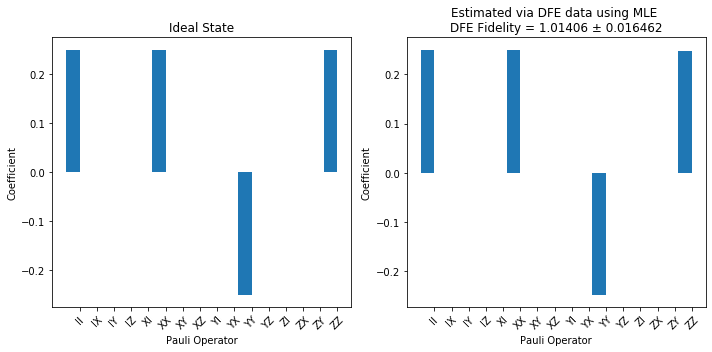

In [17]:
import matplotlib.pyplot as plt
from forest.benchmarking.utils import n_qubit_pauli_basis
from forest.benchmarking.operator_tools.superoperator_transformations import vec, computational2pauli_basis_matrix
from forest.benchmarking.plotting.state_process import plot_pauli_rep_of_state, plot_pauli_bar_rep_of_state

# convert to pauli representation
n_qubits = 2
pl_basis = n_qubit_pauli_basis(n_qubits)
c2p = computational2pauli_basis_matrix(2*n_qubits)

rho_true_pauli = np.real(c2p @ vec(rho_ideal))
rho_mle_pauli = np.real(c2p @ vec(rho_est)) 

fig1, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,5))
title_res = f"Estimated via DFE data using MLE \n" f"DFE Fidelity = {np.round(nfid_est_state, 5)} ± {np.round(nfid_std_err_state, 6)}"
plot_pauli_bar_rep_of_state(rho_true_pauli.flatten(), ax=ax3, labels=pl_basis.labels, title='Ideal State')
plot_pauli_bar_rep_of_state(rho_mle_pauli.flatten(), ax=ax4, labels=pl_basis.labels, title=title_res)
fig1.tight_layout()

To be clear, each entry on the X axis corresponds to an observable. If we ran full state tomography on the noisy state then the plot on the right would likely have small values for each entry due to noise. However, we note that to compute the fidelity we only need to estimate those entries for which the ideal state is non-zero. The plot on the right shows that we estimated exactly these four entries.

**Process DFE**

The same principle applies to process DFE, but now we must remember that for processes we vary over input states and measurements both.

In [18]:
from forest.benchmarking.tomography import pgdb_process_estimate

choi_mle_est = pgdb_process_estimate(n_results_proce, qubits)

# sneak peak at part of the estimated process
np.real_if_close(np.round(choi_mle_est, 2))[0:4]

array([[ 0.5, -0. , -0. ,  0.5, -0. ,  0.5,  0.5, -0. ,  0.5, -0. ,  0. ,
        -0.5, -0. ,  0.5, -0.5,  0. ],
       [-0. , -0. ,  0. , -0. , -0. ,  0. , -0. ,  0. , -0. , -0. , -0. ,
         0. , -0. , -0. ,  0. ,  0. ],
       [-0. ,  0. , -0. , -0. ,  0. , -0. , -0. ,  0. , -0. ,  0. , -0. ,
         0. ,  0. , -0. ,  0. , -0. ],
       [ 0.5, -0. , -0. ,  0.5, -0. ,  0.5,  0.5,  0. ,  0.5, -0. ,  0. ,
        -0.5, -0. ,  0.5, -0.5,  0. ]])

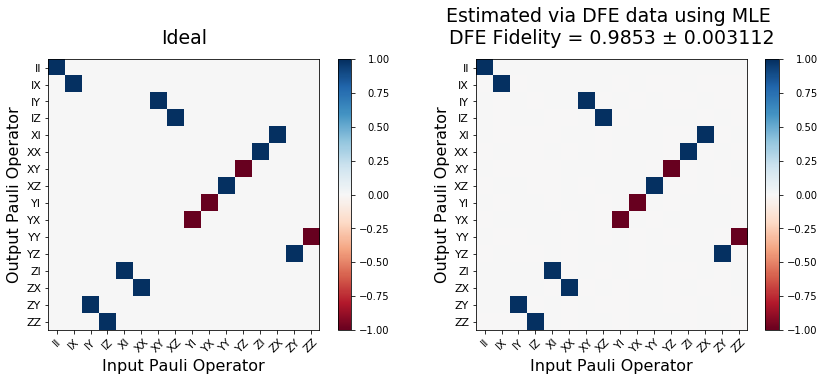

In [19]:
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix
from forest.benchmarking.operator_tools import choi2pauli_liouville, kraus2pauli_liouville


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
title_res = f"Estimated via DFE data using MLE \n" f"DFE Fidelity = {np.round(nfid_est, 5)} ± {np.round(nfid_std_err, 6)}"
plot_pauli_transfer_matrix(np.real(kraus2pauli_liouville(U_ideal)), ax1, title='Ideal')
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(choi_mle_est)), ax2, title=title_res)
plt.tight_layout()

## State fidelity between $\left|1\right\rangle$ and $|\theta\rangle = R_y(\theta)\left|1\right\rangle$


In this section we check that state DFE is working correctly by comparing with an analytical calculation. 
Essentially we would like to prepare $|1\rangle$ but we simulate an incorrect preparation $|\theta\rangle = R_y(\theta)|1\rangle$. The fidelity in that case is

$$\begin{align}
F\big(|1\rangle, |\theta\rangle \big) &= |\langle 1|R_y(\theta) |1\rangle |^2\\
&= \cos^2(\theta/2)\\
&= \frac{1}{2} \big (1 +\cos(\theta) \big). 
\end{align}$$

So the point of this section is to try to "experimentally" plot the fidelity expression as a function of $\theta$.

In [20]:
qubit = 0
ideal_prep_program = Program(X(qubit))

# generate state dfe experiment to estimate fidelity to |1 >
experiment = generate_exhaustive_state_dfe_experiment(bm, ideal_prep_program, [qubit])

To simulate the error we will modify the ideal program in the experiment to be `RY(theta, 0) X(0)` for various angles $\theta$; this is the case of unitary rotation error occurring after our ideal preparation `X(0)`.

Of course, for characterizing the actual noise on a real QPU our program would simply remain `X(0)` since this is the state preparation we hope will prepare the state $|1 \rangle$ but which in practice will be affected by noise. Here we must append our own noise `RY(theta)` to the program for the purposes of simulation.

In [21]:
points = 10
res = []
res_std_err = []


# loop over different angles
for theta in np.linspace(0, np.pi, points):
    # reuse the same experiment object but modify its program
    # field to do the "noisy" program
    experiment.program = ideal_prep_program + RY(theta, qubit)
    ry_state_data = acquire_dfe_data(qvm, experiment, num_shots=1000)
    fid_est, fid_std_err = estimate_dfe(ry_state_data, 'state')
    res.append(fid_est)
    res_std_err.append(2*fid_std_err)

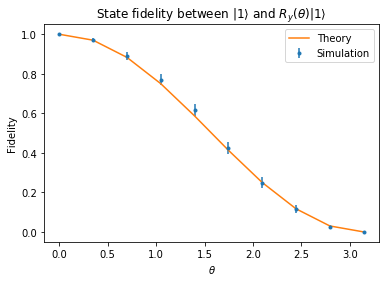

In [22]:
pyplot.errorbar(np.linspace(0, np.pi, points), res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(np.linspace(0, np.pi, points), (1/2+1/2*np.cos(np.linspace(0, np.pi, points))), label="Theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.title(r"State fidelity between $\left|1\right\rangle$ and $R_y(\theta)\left|1\right\rangle$")
pyplot.show()

as expected, the fidelity decays from the ideal with increasing values of theta.

## Process fidelity between $I$ and $R_y(\theta)$

Like the state fidelity example above we will construct a DFE experiment to estimate the fidelity between the ideal identity operation and a 'noisy identity' where we insert the unitary error $R_y(\theta)$. Then we will show that process DFE is consistent with the analytical calculation.

The process fidelity is easy to calculate using Eqn 5 from [arXiv:quant-ph/0701138](https://arxiv.org/pdf/quant-ph/0701138.pdf). The fidelity between the unitary $U_0$ and the quantum operation specified by the Kraus operators $\{ G_k \}$ is 

$$F(\{ G_k \}, U_0) 
= \frac{1}{d(d+1)} \big ( {\rm Tr}\big [\sum_k M_k^\dagger M_k \big ] + \sum_k |{\rm Tr}[ M_k]|^2 \big )$$

where $M_k = U_0^\dagger G_k$.

In the context we care about we have a single Kraus operator $\{ G_k \} = \{R_y(\theta)\}$ and $U_0=I \implies M_k = R_y(\theta)$. So the fidelity becomes

$$F\big(R_y(\theta), I \big) 
= \frac{1}{3} \big (1 +2\cos^2(\theta/2) \big )$$

where we used $R_y(\theta) = \exp[-i \theta Y /2]= \cos(\theta/2) I - i \sin(\theta/2)Y$.

In [23]:
# here our ideal program is the Identity process
qubit = 0
ideal_process_program = Program(I(qubit))

# generate process DFE experiment to estimate fidelity to I
expt = generate_exhaustive_process_dfe_experiment(bm, ideal_process_program, [qubit])

Now, as with state dfe, we will simulate noisy implementation of the identity by modifying the program that is actually run in the experiment to be `RY(theta,0)` instead of just the identity. 

As above we emphasize that modifying the program in this way only makes sense if you are inserting your own simulation of noise. To characterize real noise on a QPU the program should not be changed after generating the experiment, since the generation code tailors the experiment to the provided program.

**Note:** in some of the cells below there is a comment `# NBVAL_SKIP` that is used to speed up our tests by skipping that particular cell.

In [24]:
# NBVAL_SKIP
num_points = 10
thetas = np.linspace(0, np.pi, num_points)
res = []
res_std_err = []
for theta in thetas: 
    # modify the experiment object to do the noisy program instead
    expt.program = ideal_process_program + RY(theta, qubit)
    ry_proc_data = acquire_dfe_data(qvm, expt, num_shots=500)
    fid_est, fid_std_err = estimate_dfe(ry_proc_data, 'process')
    res.append(fid_est)
    res_std_err.append(2*fid_std_err)

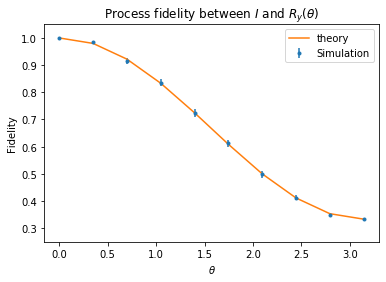

In [25]:
# NBVAL_SKIP
pyplot.errorbar(thetas, res, res_std_err, fmt=".", label="Simulation")
pyplot.plot(thetas, (1 + 2*np.cos(thetas/2)**2)/3,
            label="theory")
pyplot.xlabel(r"$\theta$")
pyplot.ylabel("Fidelity")
pyplot.legend()
pyplot.ylim(0.25, 1.05)
pyplot.title(r"Process fidelity between $I$ and $R_y(\theta)$")
pyplot.show()

## Advanced 

### Monte Carlo Sampling of large graph states

We can do [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) or random sampling of `ExperimentSettings` for large states or processes.

* `generate_monte_carlo_state_dfe_experiment`
* `generate_monte_carlo_process_dfe_experiment`

generally you need to specify the number of terms you would like to sample for the desired time savings

In [26]:
import networkx as nx
from matplotlib import pyplot as plt
from forest.benchmarking.entangled_states import create_graph_state

We will demonstrate state DFE on a graph state over 5 qubits. First, we will take some subgraph of the larger QC topology. 

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


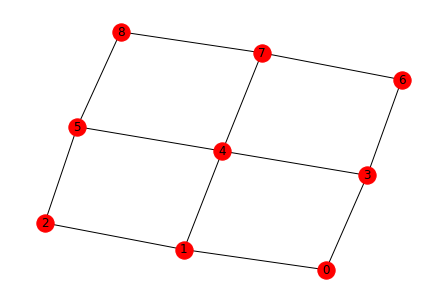

In [27]:
nx.draw(noisy_qvm.qubit_topology(), with_labels=True)

# we will do a subgraph
graph = nx.from_edgelist([(0, 1), (0, 3), (1, 2), (1, 4), (3, 4)])

We use a helper to create the prep program

In [28]:
graph_prep_prog = create_graph_state(graph)

qubits = list(graph_prep_prog.get_qubits())
print(graph_prep_prog)

H 0
H 1
H 3
H 2
H 4
CZ 0 1
CZ 0 3
CZ 1 2
CZ 1 4
CZ 3 4



Generate both exhaustive and monte_carlo experiments for comparison

In [29]:
gstate_exp_exh = generate_exhaustive_state_dfe_experiment(bm, graph_prep_prog, qubits)
gstate_exp_mc = generate_monte_carlo_state_dfe_experiment(bm, graph_prep_prog, qubits, n_terms=8)

In [30]:
num_exh_exp = len(list(gstate_exp_exh.setting_strings()))
num_mc_exp = len(list(gstate_exp_mc.setting_strings()))

print(f'In exhaustive state DFE there are {num_exh_exp} experiments.\n' )

print(f'In monte carlo state DFE we chose {num_mc_exp} experiments.' )

In exhaustive state DFE there are 31 experiments.

In monte carlo state DFE we chose 8 experiments.


Run each experiment and compare estimates and runtimes.

In [31]:
# NBVAL_SKIP

# because of the #NBVAL_SKIP `%%time` wont work
from time import time
start_time = time()

graph_state_mc_data = acquire_dfe_data(noisy_qvm, gstate_exp_mc, num_shots=500)

fid_est, fid_std_err = estimate_dfe(graph_state_mc_data, 'state')
print(f'The five qubit graph fidelity estimate is {fid_est}.\n')
print('Monte-Carlo took ', np.round(time()-start_time, 2), 'seconds.')

The five qubit graph fidelity estimate is 0.9234208202870585.

Monte-Carlo took  41.18 seconds.


In [32]:
# NBVAL_SKIP

start_time = time()

graph_state_exh_data = acquire_dfe_data(noisy_qvm, gstate_exp_exh, num_shots=500)

fid_est, fid_std_err = estimate_dfe(graph_state_exh_data, 'state')
print(f'The five qubit graph fidelity estimate is {fid_est}.\n')
print('Exhaustive took ', np.round(time()-start_time, 2), 'seconds.')

The five qubit graph fidelity estimate is 0.9395043896868677.

Exhaustive took  204.76 seconds.


### DFE measurements that include spectator qubits to signal cross talk.

Suppose you wanted to do process tomography on a CZ gate.

It turns out in many superconducting qubits there are many kinds of cross-talk at play, that is, noise which affects qubits not directly involved in the gate.


One way to measure such noise is to do the gate you care about and additionally specify spectator qubits not involved in the gate when creating the experiment.
If the actual process is not Identity on those qubits then DFE will pick it up.

Of course, such experiments are best done on the QPU or at the least with a noise model that includes these effects.

In [33]:
prog = Program(CZ(0,1))
qubits = [0,1,2]

The CZ gate is: CZ(0,1)


/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


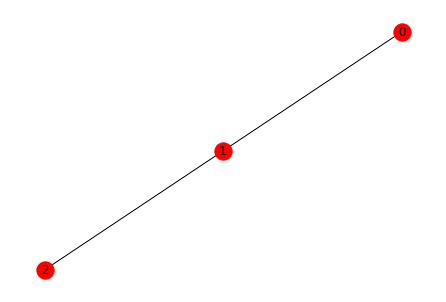

In [34]:
print('The CZ gate is: CZ(0,1)')
nx.draw(nx.from_edgelist([(0, 1), (1, 2)]), with_labels=True)

In [35]:
xtalk_proc_exp = generate_monte_carlo_process_dfe_experiment(bm, prog, qubits, n_terms=20)

In [36]:
len(list(xtalk_proc_exp.setting_strings()))

20

In [37]:
xtalk_data = acquire_dfe_data(qvm, xtalk_proc_exp, num_shots=500)

In [38]:
fid_est, fid_std_err = estimate_dfe(xtalk_data, 'process')
fid_est

1.0

Again, we expect this to be 1.0 unless we are running on a real QPU or incorporate cross-talk into the QVM noise model.

If we wanted to we could "amplify" the cross talk error by applying the gate many times

In [39]:
prog = Program([CZ(0,1)]*3)

### Parallel state and process DFE

The `ObservablesExperiment` [framework](observable_estimation.ipynb) allows for easy parallelization of experiments that operate on disjoint sets of qubits. Below we will demonstrate the simple example of performing process DFE on two separate bit flip processes `Program(X(0))` and `Program(X(1))`. To run each experiment in serial would require $n_1 + n_2 = 2n$ experimental runs ($n_1 = n_2 = n$ in this case), but when we run a 'parallel' experiment we need only $n$ runs. 

Note that the parallel experiment is not the same as doing DFE on the program `Program(X(0), X(1))` because in the later case we need to do more data acquisition runs on the qc and we get more information back; even if each process perfectly transforms the 1q states it could still behave erroneously on some 2q states but we would only catch that if we did 2q DFE. The `ExperimentSetting`s for the 2q experiment are a superset of the parallel 1q settings. We also cannot directly compare a parallel experiment with two serial experiments, because in a parallel experiment 'cross-talk' and other multi-qubit effects can impact the overall process; that is, the physics of 'parallel' experiments cannot in general be neatly factored into two serial experiments. 

See the linked [notebook](observable_estimation.ipynb) for more explanation and words of caution.

In [40]:
from forest.benchmarking.observable_estimation import ObservablesExperiment, merge_disjoint_experiments

disjoint_sets_of_qubits = [(0,),(1,)]
programs = [Program(X(*q)) for q in disjoint_sets_of_qubits]

expts_to_parallelize = []
for qubits, program in zip(disjoint_sets_of_qubits, programs):
    expt = generate_exhaustive_process_dfe_experiment(bm, program, qubits)
    expts_to_parallelize.append(expt)

# get a merged experiment with grouped settings for parallel data acquisition
parallel_expt = merge_disjoint_experiments(expts_to_parallelize)

print(f'Original number of runs: {sum(len(expt) for expt in expts_to_parallelize)}')
print(f'Parallelized number of runs: {len(parallel_expt)}\n')
print(parallel_expt)

Original number of runs: 12
Parallelized number of runs: 6

X 0; X 1
0: X+_0→(1+0j)*X0, X+_1→(1+0j)*X1
1: X-_0→(-1+0j)*X0, X-_1→(-1+0j)*X1
2: Y+_0→(-1+0j)*Y0, Y+_1→(-1+0j)*Y1
3: Y-_0→(1-0j)*Y0, Y-_1→(1-0j)*Y1
4: Z+_0→(-1+0j)*Z0, Z+_1→(-1+0j)*Z1
5: Z-_0→(1-0j)*Z0, Z-_1→(1-0j)*Z1


Collect the data. Separate the results by qubit to get back estimates for each process.

(0.9988672847543816, 0.007037532516941518)
(1.0156912964835694, 0.0074100435152986465)


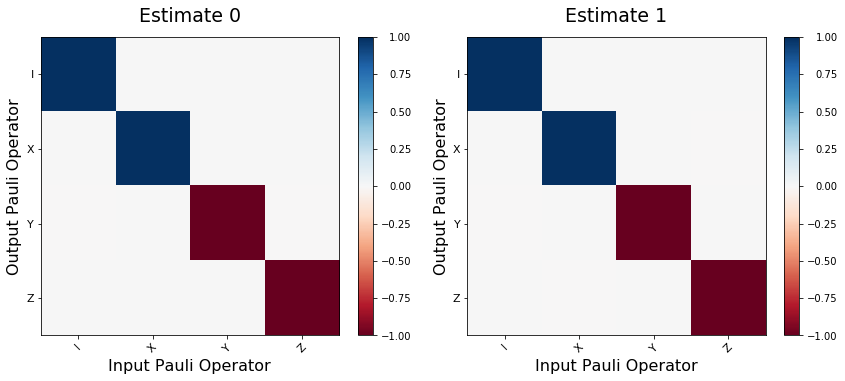

In [41]:
from forest.benchmarking.observable_estimation import get_results_by_qubit_groups

parallel_results = acquire_dfe_data(noisy_qvm, parallel_expt, num_shots = 500)

individual_results = get_results_by_qubit_groups(parallel_results, disjoint_sets_of_qubits)

fidelity_estimates = []
process_estimates = []
for q in disjoint_sets_of_qubits:
    fidelity_estimate = estimate_dfe(individual_results[q], 'process')
    fidelity_estimates.append(fidelity_estimate)
    print(fidelity_estimate)
    
    proc_estimate = pgdb_process_estimate(individual_results[q], q)
    process_estimates.append(proc_estimate)

fig, axes = plt.subplots(1, len(process_estimates), figsize=(12,5))
for idx, est in enumerate(process_estimates):
    plot_pauli_transfer_matrix(choi2pauli_liouville(est), axes[idx], title=f'Estimate {idx}')

plt.tight_layout()
